In [1]:
import re
import ftfy
import nltk
import itertools
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from math import exp
import pickle as pkl
from numpy import sign
from pathlib import Path
from nltk import PorterStemmer
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.models import Model, Sequential
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D

Using TensorFlow backend.


In [2]:
np.random.seed(1234)

In [3]:
no_rows_pos = 3200
no_rows_neg = 12000
max_length = 140
nb_max_words = 20000
embedding_dim = 300

In [4]:
dep_tweets_file_path = 'input/depressive_tweets.csv'
non_dep_tweets_file_path = 'input/non_depressive_tweets.csv'
embedding_file_path = 'input/google_news_vectors_negative_300.bin'

In [5]:
df_dep_tweets = pd.read_csv(dep_tweets_file_path, nrows = no_rows_pos, encoding = "ISO-8859-1", usecols=(1,2))
df_non_dep_tweets = pd.read_csv(non_dep_tweets_file_path, nrows = no_rows_neg, encoding = "ISO-8859-1", usecols=(1,2))


In [6]:
df_dep_tweets.head()

,TextId,Text
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


In [7]:
df_non_dep_tweets.head()

,user,text
0,whosalli,The lack of this understanding is a small but ...
1,estermnunes,i just told my parents about my depression and...
2,TheAlphaAries,depression is something i don't speak about ev...
3,_ojhodgson,Made myself a tortilla filled with pb&j. My de...
4,DMiller96371630,@WorldofOutlaws I am gonna need depression med...


In [8]:
word2vec = KeyedVectors.load_word2vec_format(embedding_file_path, binary=True)

In [9]:
cList = pkl.load(open('input/cword_dict.pkl','rb'))

In [10]:
print(cList)

{"ain't": 'am not', "aren't": 'are not', "can't": 'cannot', "can't've": 'cannot have', "'cause": 'because', "could've": 'could have', "couldn't": 'could not', "couldn't've": 'could not have', "didn't": 'did not', "doesn't": 'does not', "don't": 'do not', "hadn't": 'had not', "hadn't've": 'had not have', "hasn't": 'has not', "haven't": 'have not', "he'd": 'he would', "he'd've": 'he would have', "he'll": 'he will', "he'll've": 'he will have', "he's": 'he is', "how'd": 'how did', "how'd'y": 'how do you', "how'll": 'how will', "how's": 'how is', "I'd": 'I would', "I'd've": 'I would have', "I'll": 'I will', "I'll've": 'I will have', "I'm": 'I am', "I've": 'I have', "isn't": 'is not', "it'd": 'it had', "it'd've": 'it would have', "it'll": 'it will', "it'll've": 'it will have', "it's": 'it is', "let's": 'let us', "ma'am": 'madam', "mayn't": 'may not', "might've": 'might have', "mightn't": 'might not', "mightn't've": 'might not have', "must've": 'must have', "mustn't": 'must not', "mustn't've"

In [11]:
c_re = re.compile('(%s)' % '|'.join(cList.keys()))

In [12]:
def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [13]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            tweet = ftfy.fix_text(tweet)
            tweet = expandContractions(tweet)
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())
            stop_words = stopwords.words('english')
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)
            tweet = PorterStemmer().stem(tweet)
            cleaned_tweets.append(tweet)
    return cleaned_tweets

In [14]:
arr_dep_tweets = [x for x in df_dep_tweets['Text']]
arr_non_dep_tweets = [x for x in df_non_dep_tweets['text']]

In [30]:
cleaned_dep_text = clean_tweets(arr_dep_tweets)
cleaned_non_dep_text = clean_tweets(arr_non_dep_tweets)

In [31]:
tokenizer = Tokenizer(num_words=nb_max_words)
tokenizer.fit_on_texts(cleaned_dep_text + cleaned_non_dep_text)

In [32]:
sequences_dep = tokenizer.texts_to_sequences(cleaned_dep_text)
sequences_non_dep = tokenizer.texts_to_sequences(cleaned_non_dep_text)

In [33]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 12061 unique tokens


In [34]:
data_dep = pad_sequences(sequences_dep, maxlen=max_length)
data_non_dep = pad_sequences(sequences_non_dep, maxlen=max_length)
print('Shape of data_dep tensor:', data_dep.shape)
print('Shape of data_non_dep tensor:', data_non_dep.shape)

Shape of data_dep tensor: (3165, 140)
Shape of data_non_dep tensor: (2319, 140)


In [36]:
nb_words = min(nb_max_words, len(word_index))

embedding_matrix = np.zeros((nb_words, embedding_dim))

for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < nb_max_words:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [37]:
print(data_dep.shape, data_non_dep.shape)

(3165, 140) (2319, 140)


In [38]:
data = np.concatenate((data_dep, data_non_dep))

In [39]:
labels_dep = np.ones(data_dep.shape[0])
labels_non_dep = np.zeros(data_non_dep.shape[0])
print(labels_dep.shape, labels_non_dep.shape)

(3165,) (2319,)


In [40]:
labels = np.concatenate((labels_dep, labels_non_dep))

In [41]:
print(data.shape, labels.shape)

(5484, 140) (5484,)


In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size = 0.2, random_state=42)

In [43]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(4387, 140) (4387,) (1097, 140) (1097,)


In [45]:
f = Path('model/model_structure.json')
model_structure = f.read_text()
model = model_from_json(model_structure)

In [49]:
adam = Adam(lr=0.001,
    decay=1e-06
)

In [50]:
model.compile(
    loss='binary_crossentropy',
    optimizer=adam,
    metrics=['accuracy']
)

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 300)          6000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 140, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 70, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               399600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total para

In [46]:
hist = model.fit(
    X_train,
    Y_train,
    validation_data=(X_test, Y_test),
    epochs=5,
    batch_size=40,
    shuffle=True
)

Train on 4387 samples, validate on 1097 samples
Epoch 1/5
4387/4387 [==============================] - 21s 5ms/step - loss: 0.3918 - acc: 0.8197 - val_loss: 0.1488 - val_acc: 0.9453
Epoch 2/5
4387/4387 [==============================] - 19s 4ms/step - loss: 0.1192 - acc: 0.9649 - val_loss: 0.1015 - val_acc: 0.9745
Epoch 3/5
4387/4387 [==============================] - 20s 4ms/step - loss: 0.0871 - acc: 0.9758 - val_loss: 0.0886 - val_acc: 0.9745
Epoch 4/5
4387/4387 [==============================] - 20s 5ms/step - loss: 0.0723 - acc: 0.9809 - val_loss: 0.0902 - val_acc: 0.9727
Epoch 5/5
4387/4387 [==============================] - 21s 5ms/step - loss: 0.0655 - acc: 0.9809 - val_loss: 0.0900 - val_acc: 0.9763


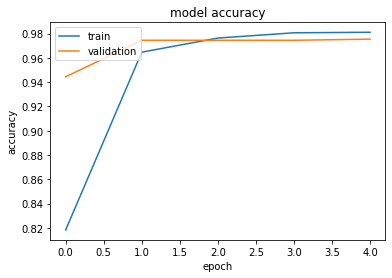

In [34]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

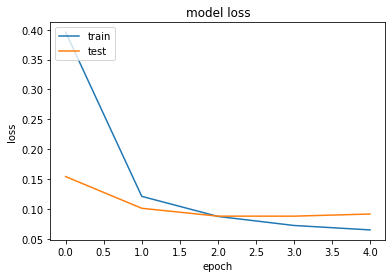

In [35]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred.flatten())

In [37]:
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 97.54%


In [38]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       445
         1.0       0.97      0.99      0.98       652

    accuracy                           0.98      1097
   macro avg       0.98      0.97      0.97      1097
weighted avg       0.98      0.98      0.98      1097



In [39]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix'):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap='binary')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30)
    plt.yticks(tick_marks, classes, rotation=30)
    
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [40]:
cm = confusion_matrix(y_pred=Y_pred, y_true=Y_test)

In [41]:
print(confusion_matrix(y_pred=Y_pred, y_true=Y_test))

[[424  21]
 [  6 646]]


In [42]:
cm_plot_labels = ['Non-Depressed', 'Depressed']

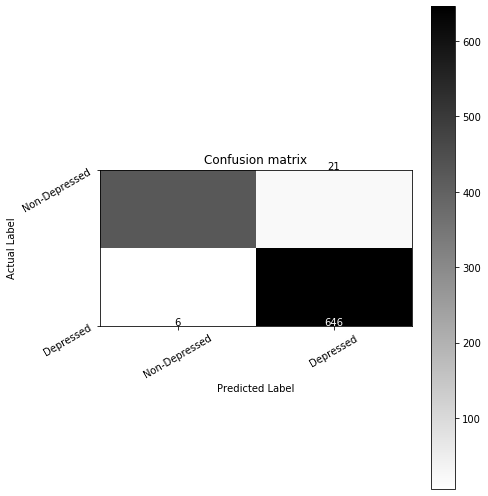

In [43]:
plot_confusion_matrix(cm,cm_plot_labels)

In [44]:
model.save_weights("model/model_weights.h5")

# Done